In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib
from sklearn.metrics import roc_curve, auc
import seaborn as sns

import lightgbm as lgb
import utils

#supression warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load data

In [2]:
data_path = './data/jlr_all_user_processed.xlsx'
df = pd.read_excel(data_path)
df.head(3)

,user_id,follow_count,fans_count,gender,birthday,location,level,registration_time,properties,mileage,...,car_friend_zone,label,car_like,excellent_post_count,all_post_count,regis_year,regis_month,regis_day,date,date_delta
0,oden123,0,0,2,NaT,1,1,2018-03-26,1,4430,...,NaN,True,1,0,0,2018,3,3,2018-03-26,4522
1,生活1934626,2,4,2,NaT,2,1,2012-05-07,1,4270,...,"[{'名称': '汽车之家甘肃论坛车友会', '人数': 672, '创建时间': '201...",True,2,0,0,2012,5,5,2012-05-07,2373
2,wangzi1125,0,1,2,NaT,3,1,2017-06-18,1,2090,...,NaN,True,3,0,1,2017,6,6,2017-06-18,4241


In [3]:
# df.keys(), df.dtypes

### Data choosing  
we choose some features to build the machine learning model

In [4]:
x = df.drop(columns=[
                      'user_id',
#                      'follow_count',
#                      'fans_count', 
                     'gender', 
                      'birthday',
#                      'location',
                     'level',
                      'registration_time',
                     'properties',
#                      'mileage',
                      'post',
                      'cars',
                      'koubei_post',
                      'gas_mileage',
                      'car_friend_zone',
                      'label',
#                      'car_like', 
                     'excellent_post_count',
                     'all_post_count',
                      'regis_year',
                      'regis_month',
                      'regis_day', 
                      'date',
#                      'date_delta'
                     ])
x.head(2)

,follow_count,fans_count,location,mileage,car_like,date_delta
0,0,0,1,4430,1,4522
1,2,4,2,4270,2,2373


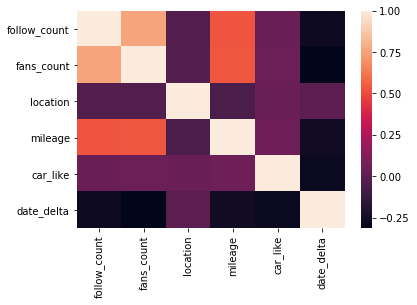

In [5]:
# faeture heat map
import matplotlib.pyplot as plt
import seaborn as sns
# data = pd.read_csv("../input/car_crashes.csv")
data = x.corr()
sns.heatmap(data)
plt.show()

In [5]:
y = df['label'].astype('uint8')
utils.exploreCat(df, 'label')

In [6]:
# dataset size
_x, _y = np.array(x).astype('int'), np.array(y).astype('int')
_x.shape, _y.shape

((5555, 6), (5555,))

### Split dataset into train/validation/test set
train:validation:test = 8:1:1

In [7]:
x_train, x_test, y_train, y_test = train_test_split(_x, _y, test_size=0.2,  random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5,  random_state = 42)

In [8]:
print(x_train.shape, x_val.shape, x_test.shape)

(4444, 6) (555, 6) (556, 6)


In [9]:
# positive/negative propotion in dataset
print("In train set, positive : negative = {}:{}=1:{} ".format(sum(y_train==1),sum(y_train==0), sum(y_train==0)/sum(y_train==1)))
print("In validation set, positive : negative = {}:{}=1:{}".format(sum(y_val==1),sum(y_val==0), sum(y_val==0)/sum(y_val==1)))
print("In test set, positive : negative = {}:{}=1:{}".format(sum(y_test==1),sum(y_test==0),sum(y_test==0)/sum(y_test==1)))

In train set, positive : negative = 578:3866=1:6.688581314878893 
In validation set, positive : negative = 67:488=1:7.2835820895522385
In test set, positive : negative = 80:476=1:5.95


### Build SVM model then train with above dataset

In [10]:
clf = SVC(C=0.8, kernel='rbf', class_weight='balanced')

In [11]:
clf.fit(x_train, y_train)

SVC(C=0.8, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
pred = clf.predict(x_test)

In [13]:
print(classification_report(y_true=y_test, y_pred=pred))

             precision    recall  f1-score   support

          0       0.85      0.92      0.88       476
          1       0.03      0.01      0.02        80

avg / total       0.73      0.79      0.76       556



### Build lightgbm model and train with above dataset

In [68]:
# Lightgbm dataset construction

# train_data = lgb.Dataset(x_train, label=y_train)
# val_data = lgb.Dataset(x_val, label=y_val)
# test_data = lgb.Dataset(x_test, label = y_test)

feature_name = list(x.keys())
categorical_feature = [
#                        'gender',
                       'location',
#                        'level', 
#                        'properties', 
                       'car_like',
                     #'regis_year', 'regis_month', 'regis_day',
                                            ]
train_data = lgb.Dataset(x_train, 
                         label=y_train,
                         feature_name=feature_name,
                         categorical_feature=categorical_feature,
                        )
val_data = lgb.Dataset(x_val,
                       label=y_val,
                       feature_name=feature_name,
                       categorical_feature=categorical_feature,
                      )
test_data = lgb.Dataset(x_test, 
                        label = y_test,
                        feature_name=feature_name,
                        categorical_feature=categorical_feature,
                       )
# feature_name, categorical_feature

#### Setting parameters

In [67]:
# para searching
params = {
    'boosting_type': 'gbdt',  # np.random.choice(['dart', 'gbdt']),
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'], 
    
    'learning_rate': 0.30,
    
    'num_leaves': np.random.randint(10,12),
    'max_depth': np.random.randint(7,10),
    'min_data_in_leaf': int(2 ** (np.random.rand()*1.5 + 5)),
    
    'feature_fraction': np.random.rand()*0.35+0.65,
    'bagging_fraction': np.random.rand()*0.35+0.65,
    'bagging_freq': 1,
    
    'lambda_l1': 10 ** (np.random.rand() * 4),
    'lambda_l2': 10 ** (np.random.rand() * 3 + 2),
    'min_gain_to_split': 0.0,
    'min_sum_hessian_in_leaf': 0.1,
    
    'num_threads': 16,
    'verbose': 0,
    'is_training_metric': 'True'
}
print('Hyper-parameters:')
print(params)

Hyper-parameters:
{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': ['binary_logloss', 'auc'], 'learning_rate': 0.3, 'num_leaves': 11, 'max_depth': 7, 'min_data_in_leaf': 52, 'feature_fraction': 0.6738689371062005, 'bagging_fraction': 0.8289967992224982, 'bagging_freq': 1, 'lambda_l1': 8.115978557126892, 'lambda_l2': 17873.78060382777, 'min_gain_to_split': 0.0, 'min_sum_hessian_in_leaf': 0.1, 'num_threads': 16, 'verbose': 0, 'is_training_metric': 'True'}


#### Training 

In [69]:
evals_result = {}  # dict to store evaluation results of all the items in `valid_sets`

gbm = lgb.train(params, 
                train_data, 
                num_boost_round=10000, 
                valid_sets=[train_data, val_data], 
                valid_names = ['train', 'valid'], 
                evals_result=evals_result, 
                early_stopping_rounds=3000, 
                verbose_eval=100)

Training until validation scores don't improve for 3000 rounds.
[100]	train's auc: 0.788469	train's binary_logloss: 0.369613	valid's auc: 0.717626	valid's binary_logloss: 0.356188
[200]	train's auc: 0.793841	train's binary_logloss: 0.357488	valid's auc: 0.715072	valid's binary_logloss: 0.348215
[300]	train's auc: 0.798024	train's binary_logloss: 0.348019	valid's auc: 0.718635	valid's binary_logloss: 0.342261
[400]	train's auc: 0.801153	train's binary_logloss: 0.340007	valid's auc: 0.718528	valid's binary_logloss: 0.337586
[500]	train's auc: 0.803743	train's binary_logloss: 0.333755	valid's auc: 0.720746	valid's binary_logloss: 0.334111
[600]	train's auc: 0.80695	train's binary_logloss: 0.328636	valid's auc: 0.722627	valid's binary_logloss: 0.331315
[700]	train's auc: 0.80945	train's binary_logloss: 0.324461	valid's auc: 0.724431	valid's binary_logloss: 0.329159
[800]	train's auc: 0.811943	train's binary_logloss: 0.320795	valid's auc: 0.726174	valid's binary_logloss: 0.327277
[900]	trai

[7100]	train's auc: 0.866648	train's binary_logloss: 0.269877	valid's auc: 0.747614	valid's binary_logloss: 0.30961
[7200]	train's auc: 0.867191	train's binary_logloss: 0.269559	valid's auc: 0.747767	valid's binary_logloss: 0.309646
[7300]	train's auc: 0.867696	train's binary_logloss: 0.269234	valid's auc: 0.747767	valid's binary_logloss: 0.309662
[7400]	train's auc: 0.868143	train's binary_logloss: 0.268951	valid's auc: 0.747798	valid's binary_logloss: 0.309692
[7500]	train's auc: 0.868529	train's binary_logloss: 0.268671	valid's auc: 0.74737	valid's binary_logloss: 0.309774
[7600]	train's auc: 0.869019	train's binary_logloss: 0.268369	valid's auc: 0.747614	valid's binary_logloss: 0.309824
[7700]	train's auc: 0.86943	train's binary_logloss: 0.268093	valid's auc: 0.747553	valid's binary_logloss: 0.309936
[7800]	train's auc: 0.869918	train's binary_logloss: 0.267802	valid's auc: 0.747461	valid's binary_logloss: 0.309973
[7900]	train's auc: 0.870371	train's binary_logloss: 0.267536	valid

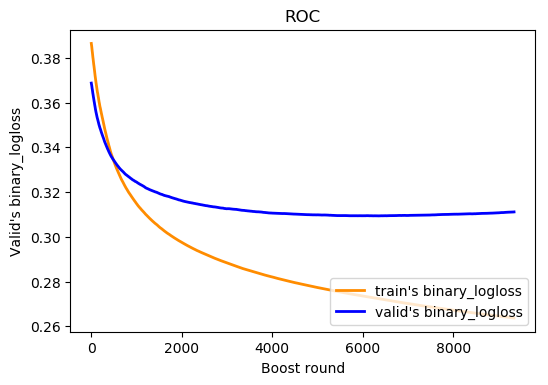

In [70]:
train_auc_log = evals_result['train']['binary_logloss']
# type(train_auc_log)
# len(train_auc_log)
val_auc_log = evals_result['valid']['binary_logloss']

# plot training logs
plt.figure()
plt.rcParams['savefig.dpi'] = 50 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率
lw = 2
plt.plot(range(len(train_auc_log)),train_auc_log, color='darkorange',
         lw=lw, label="train's binary_logloss")
plt.plot(range(len(val_auc_log)),val_auc_log, color='blue',
         lw=lw, label="valid's binary_logloss")
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('Boost round')
plt.ylabel("Valid's binary_logloss")
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [71]:
# save best round results to csv
bst_round = np.argmax(evals_result['valid']['auc'])
trn_auc = evals_result['train']['auc'][bst_round]
trn_loss = evals_result['train']['binary_logloss'][bst_round]
val_auc = evals_result['valid']['auc'][bst_round]
val_loss = evals_result['valid']['binary_logloss'][bst_round]

In [72]:
print('Best Round: %d'%bst_round)
print('Training loss: %.5f, Validation loss: %.5f'%(trn_loss, val_loss))
print('Training AUC : %.5f, Validation AUC : %.5f'%(trn_auc, val_auc))

# save model to file
model_save_path = './models/trn_auc' + str(trn_auc)[:5] + '_' + 'val_auc' + str(val_auc)[:5] + '.txt'
print('Save model to file: {}'.format(model_save_path))
gbm.save_model(model_save_path)

Best Round: 7220
Training loss: 0.26949, Validation loss: 0.30962
Training AUC : 0.86727, Validation AUC : 0.74792
Save model to file: ./models/trn_auc0.867_val_auc0.747.txt


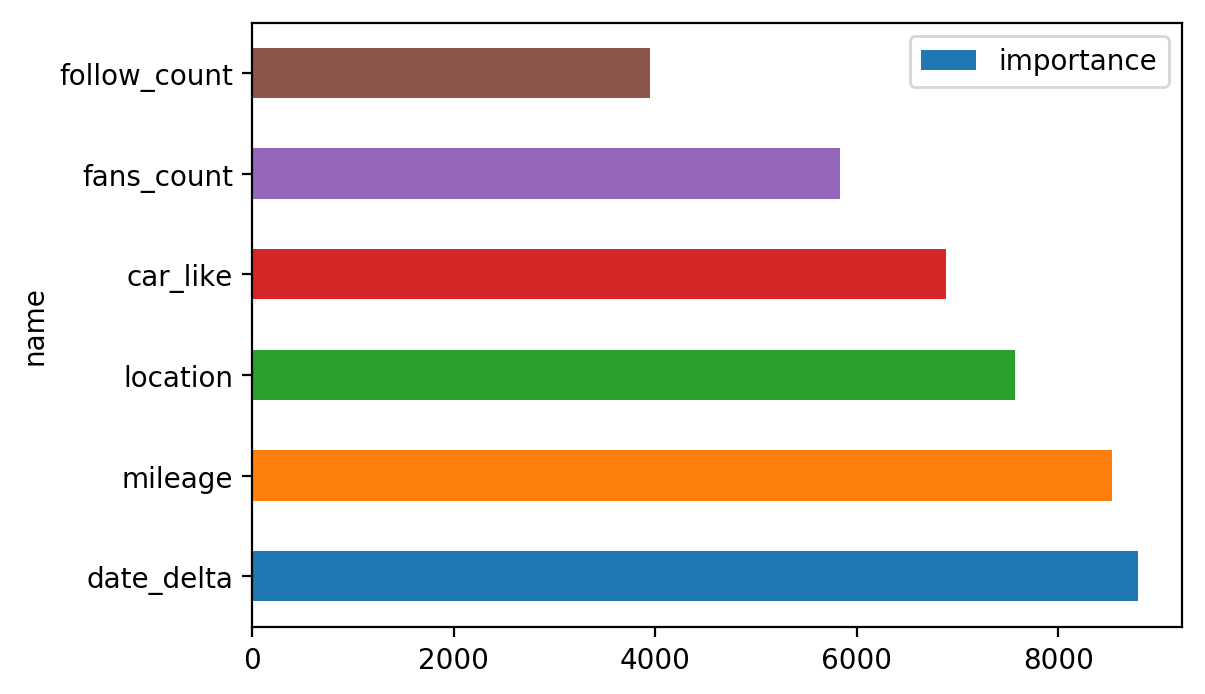

In [73]:
feature_importance = pd.DataFrame({'name':gbm.feature_name(), 'importance':gbm.feature_importance()}).sort_values(by='importance', ascending=False)
feature_importance.to_csv('./feat_importance.csv', index=False)
# fig = matplotlib.pyplot.gcf()
# fig.set_size_inches(15, 5)
plt.rcParams['savefig.dpi'] = 50 #图片像素
plt.rcParams['figure.dpi'] = 200 #分辨率
feature_importance.plot(x='name', y='importance',kind='barh')
# plt.savefig('plot123_2.png', dpi=300) 
plt.show()

#### Using best model for Testing 

Load model to predict
             precision    recall  f1-score   support

          0       0.89      0.99      0.94       476
          1       0.79      0.29      0.42        80

avg / total       0.88      0.89      0.86       556

roc_auc:  0.6374474789915967


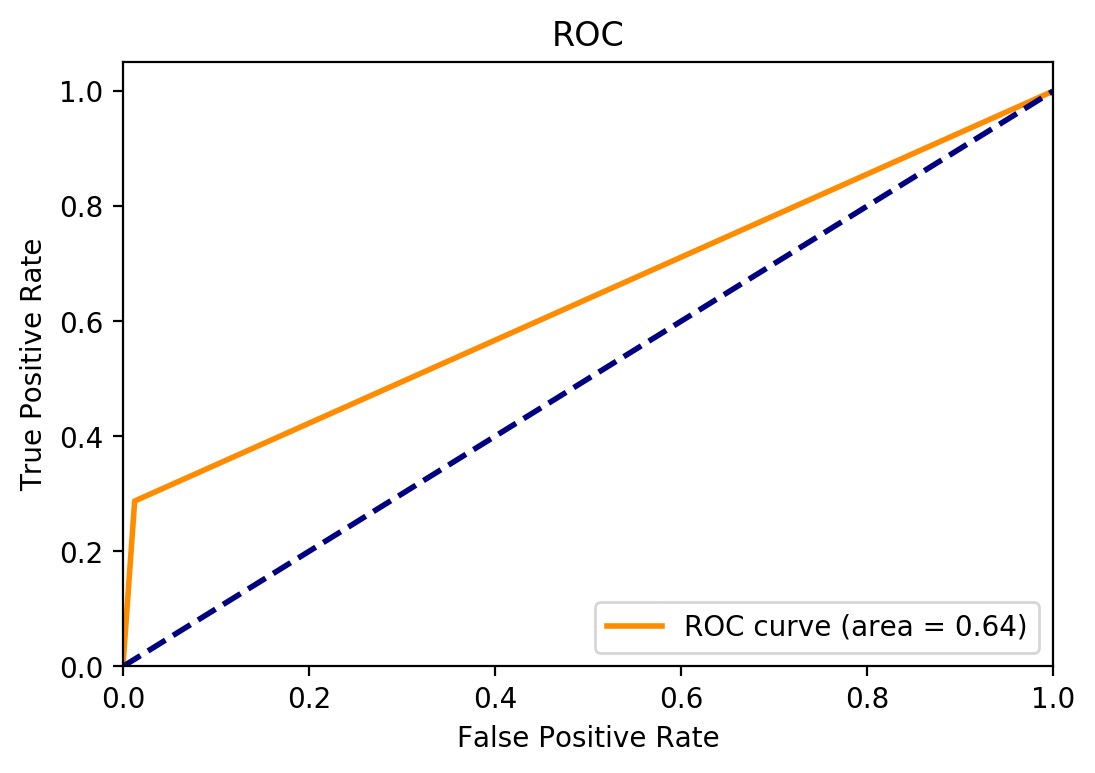

In [74]:
# load model to predict
print('Load model to predict')
gbm = lgb.Booster(model_file=model_save_path)
                  
y_pred = gbm.predict(x_test)
# print(y_pred[:10])

y_pred = y_pred >= 0.5
# print(y_pred[:10])

from sklearn.metrics import accuracy_score, confusion_matrix
# print(accuracy_score(y_test, y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

# AUC 
fpr, tpr,_ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("roc_auc: ",roc_auc)

# plot ROC
plt.figure()
plt.rcParams['savefig.dpi'] = 50 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()